# February 22-23, 2023: Linear stochastic model: power law degree distribution network: subjects x runs functional connectivity matrices

In [1]:
import csv
import os
import pickle
import random
import sys
from os.path import join as pjoin
import numpy as np
import scipy as sp 
from scipy.spatial.distance import pdist, cdist, squareform
from scipy import stats
import tvb
import networkx as nx
import copy
import matlab.engine
from itertools import product
from tqdm import tqdm

sys.path.append("/usr/local/MATLAB/R2022b/bin/matlab")

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_estimation')
month_dir = f"{proj_dir}/nb/feb23"
bdmodels_dir = f"{proj_dir}/helpers/bdmodels"
networks_dir = f"{proj_dir}/helpers/networks"

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# folders
sys.path.insert(0, proj_dir)
# import helpers.dataset_utils_v1 as dataset_utils
# import helpers.fc_utils as fc_utils
# import helpers.isc_utils as isc_utils
# import helpers.network_utils as network_utils

In [2]:
def generate_roi_group(args, group=0, idx_subj=0):
    graph_generator = args.networks[idx_subj].graph_generator
    params = args.networks[idx_subj].params
    params_list = [p for p in params if type(p) is not dict]
    params_dict = [p for p in params if type(p) is dict]
    if len(params_list) > 0 and len(params_dict) == 0:
        G = graph_generator(*params_list)
    elif len(params_list) == 0 and len(params_dict) > 0:
        G = graph_generator(**params_dict[0])
    else:
        G = graph_generator(*params_list, **params_dict[0])
    
    W = nx.to_numpy_array(G)
    # weights = np.triu(np.random.rand(args.num_rois[group], args.num_rois[group]), k=1)
    # weights = (weights + weights.T)/2
    # weights *= W
    weights = args.scale['group'] * W

    label = args.group_label[group]
    roi_labels = [f"{label}_{roi:02}" for roi in range(args.num_rois[group])]

    return (
        weights, 
        roi_labels,
    )

In [3]:
def display_networks(args, networks) -> None:
    nrows, ncols = 1, len(networks)
    figsize = (5*ncols, 4*nrows)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=figsize,
        sharex=True, 
        sharey=True, 
        dpi=120,
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    for idx, network in enumerate(networks):
        ax = axs[idx]
        im = ax.imshow(network, cmap=args.cmap)
        ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        ax.set_title(f"{idx:02}: {args.networks[idx].name}")
        # set_matrix_ticks(args, ax)

    return None

def display_fcs(args, networks, fcs) -> None:
    nrows, ncols = args.num_subjs, 1+args.num_runs
    figsize = (5*ncols, 4*nrows)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=figsize,
        sharex=True, 
        sharey=True, 
        dpi=120,
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=None
    )

    for idx_subj, network in enumerate(networks):
        ax = axs[idx_subj, 0]
        im = ax.imshow(network, cmap=args.cmap)
        ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        ax.set_ylabel(f"subj{idx_subj:02}",fontsize='large')
        ax.set_title(f"{args.networks[idx_subj].name}")
        # set_matrix_ticks(args, ax)

    for (idx_subj, idx_run) in tqdm(
        list(product(range(args.num_subjs), range(args.num_runs)))
    ):
        ax = axs[idx_subj, idx_run+1]
        im = ax.imshow(fcs[f"subj{idx_subj:02}"][f"run{idx_run:02}"], cmap=args.cmap)
        ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        ax.set_ylabel(f"subj{idx_subj:02}",fontsize='large')
        ax.set_title(f"sig. {args.sigmas[idx_run]:.1f}")
        # set_matrix_ticks(args, ax)

    return None

In [4]:
def to_python_vars(out_dict):
    for k, v in out_dict.items():
        out_dict[k] = np.array(v.tomemoryview().tolist())

    out_dict['t'] = out_dict['t'].squeeze()
    out_dict['x'] = out_dict['x'].T

    return out_dict
    
def simulate(eng, model_path, model, in_dict):
    eng.cd(model_path)
    out_dict = model(in_dict, nargout=1)
    out_dict = to_python_vars(out_dict)

    return out_dict

In [5]:
def plot_roi_time_series(args, time, data, roi_labels=None):
    # plot the time series of all rois.
    # %matplotlib inline
    if args.subplot_layout == 'row-col':
        nrows, ncols = int(np.ceil(args.num_rois / 5)), 5
        figsize = (5*ncols, 4*nrows)
    elif args.subplot_layout == 'row':
        nrows, ncols = args.num_rois, 1
        figsize = (10*ncols, 4*nrows)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=figsize,
        sharex=False, 
        sharey=True, 
        dpi=120,
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.65
    )

    for idx_roi, roi in enumerate(np.arange(data.shape[-1])):
        if args.subplot_layout == 'row-col':
            ax = axs[idx_roi // ncols, idx_roi % ncols]
        elif args.subplot_layout == 'row':
            ax = axs[idx_roi]
        
        if roi_labels is not None:
            ax.set_title(f"{roi_labels[roi]}")
        else:
            ax.set_title(f"roi {idx_roi:02}")

        ax.plot(
            time,
            data[:, idx_roi],
            color='cornflowerblue',
            linewidth=3,
        )

        ax.plot(
            time,
            np.zeros_like(data[:, idx_roi]),
            color='black',
            linewidth=1.5,
            linestyle='-.',
            alpha=0.5
        )

        ax.set_xlabel(f"time (ms)")
        ax.set_ylabel(f"activity")

        ax.grid(True)

    # fig.show()

    return None

In [6]:
class ARGS(): pass
args = ARGS()

args.SEED = 100
np.random.seed(args.SEED)
args.num_rois = np.array([10])
args.m = [2, 2]
args.p = [0.1, 0.1]
args.scale = {'group':1.0, 'inter':1.5}
args.group_label = ['A', 'B']

args.tspan = [0, 100]
args.delta_t = 0.1

args.num_subjs = 9
args.num_runs = 3
args.SEEDS = np.random.randint(low=0, high=100, size=args.num_subjs, )

## networks

In [7]:
args.networks = [ARGS() for _ in range(args.num_subjs)]

args.networks[0].name = 'comp.mult.part.'
args.networks[0].graph_generator = nx.complete_multipartite_graph
args.networks[0].params = [3, 4, 3]

args.networks[1].name = 'circ.ladder'
args.networks[1].graph_generator = nx.circular_ladder_graph
args.networks[1].params = [5]

args.networks[2].name = 'watts strogzts'
args.networks[2].graph_generator = nx.watts_strogatz_graph
args.networks[2].params = [{'n':10, 'k':2, 'p':0.4, 'seed':int(args.SEEDS[2])}]

args.networks[3].name = 'barabasi albert'
args.networks[3].graph_generator = nx.extended_barabasi_albert_graph
args.networks[3].params = [{'n':10, 'm':2, 'p':0.05, 'q':0.4, 'seed':int(args.SEEDS[3])}]

args.networks[4].name = 'powerlaw'
args.networks[4].graph_generator = nx.powerlaw_cluster_graph
args.networks[4].params = [{'n':10, 'm':3, 'p':0.1, 'seed':int(args.SEEDS[4])}]

args.networks[5].name = 'tree'
args.networks[5].graph_generator = nx.random_powerlaw_tree
args.networks[5].params = [{'n':10, 'gamma':3, 'seed':int(args.SEEDS[5]), 'tries':100}]

args.networks[6].name = 'rand.geometric'
args.networks[6].graph_generator = nx.soft_random_geometric_graph
args.networks[6].params = [{'n':10, 'radius':0.25, 'dim':2, 'pos':None, 'p_dist':None, 'seed':int(args.SEEDS[6])}]

args.networks[7].name = 'gauss.partition'
args.networks[7].graph_generator = nx.gaussian_random_partition_graph
args.networks[7].params = [{'n':10, 's':3, 'v':2, 'p_in':0.5, 'p_out':0.2, 'directed':False, 'seed':int(args.SEEDS[7])}]

args.networks[8].name = 'stoch.blk.mdl.'
args.networks[8].graph_generator = nx.stochastic_block_model
args.networks[8].params = [{'sizes':[3, 4, 3], 'p':[[0.2, 0.2, 0.2], [0.2, 0.2, 0.2], [0.2, 0.2, 0.2]], 'seed':int(args.SEEDS[8])}]

100%|██████████| 9/9 [00:00<00:00, 1213.55it/s]


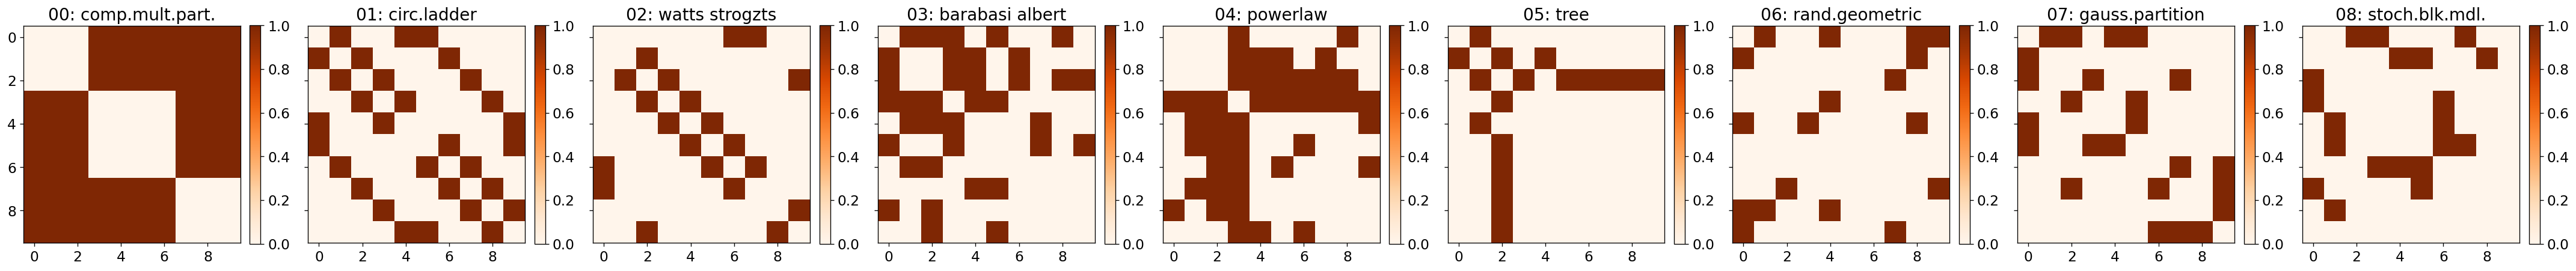

In [8]:
networks = []
for idx_subj in tqdm(range(args.num_subjs)):
    W, _ = generate_roi_group(args, idx_subj=idx_subj)
    networks.append(W)

# args.cmap = cmr.iceburn
args.cmap = mpl.colormaps['Oranges']
display_networks(args, networks)

Text(0.5, 1.0, 'fc')

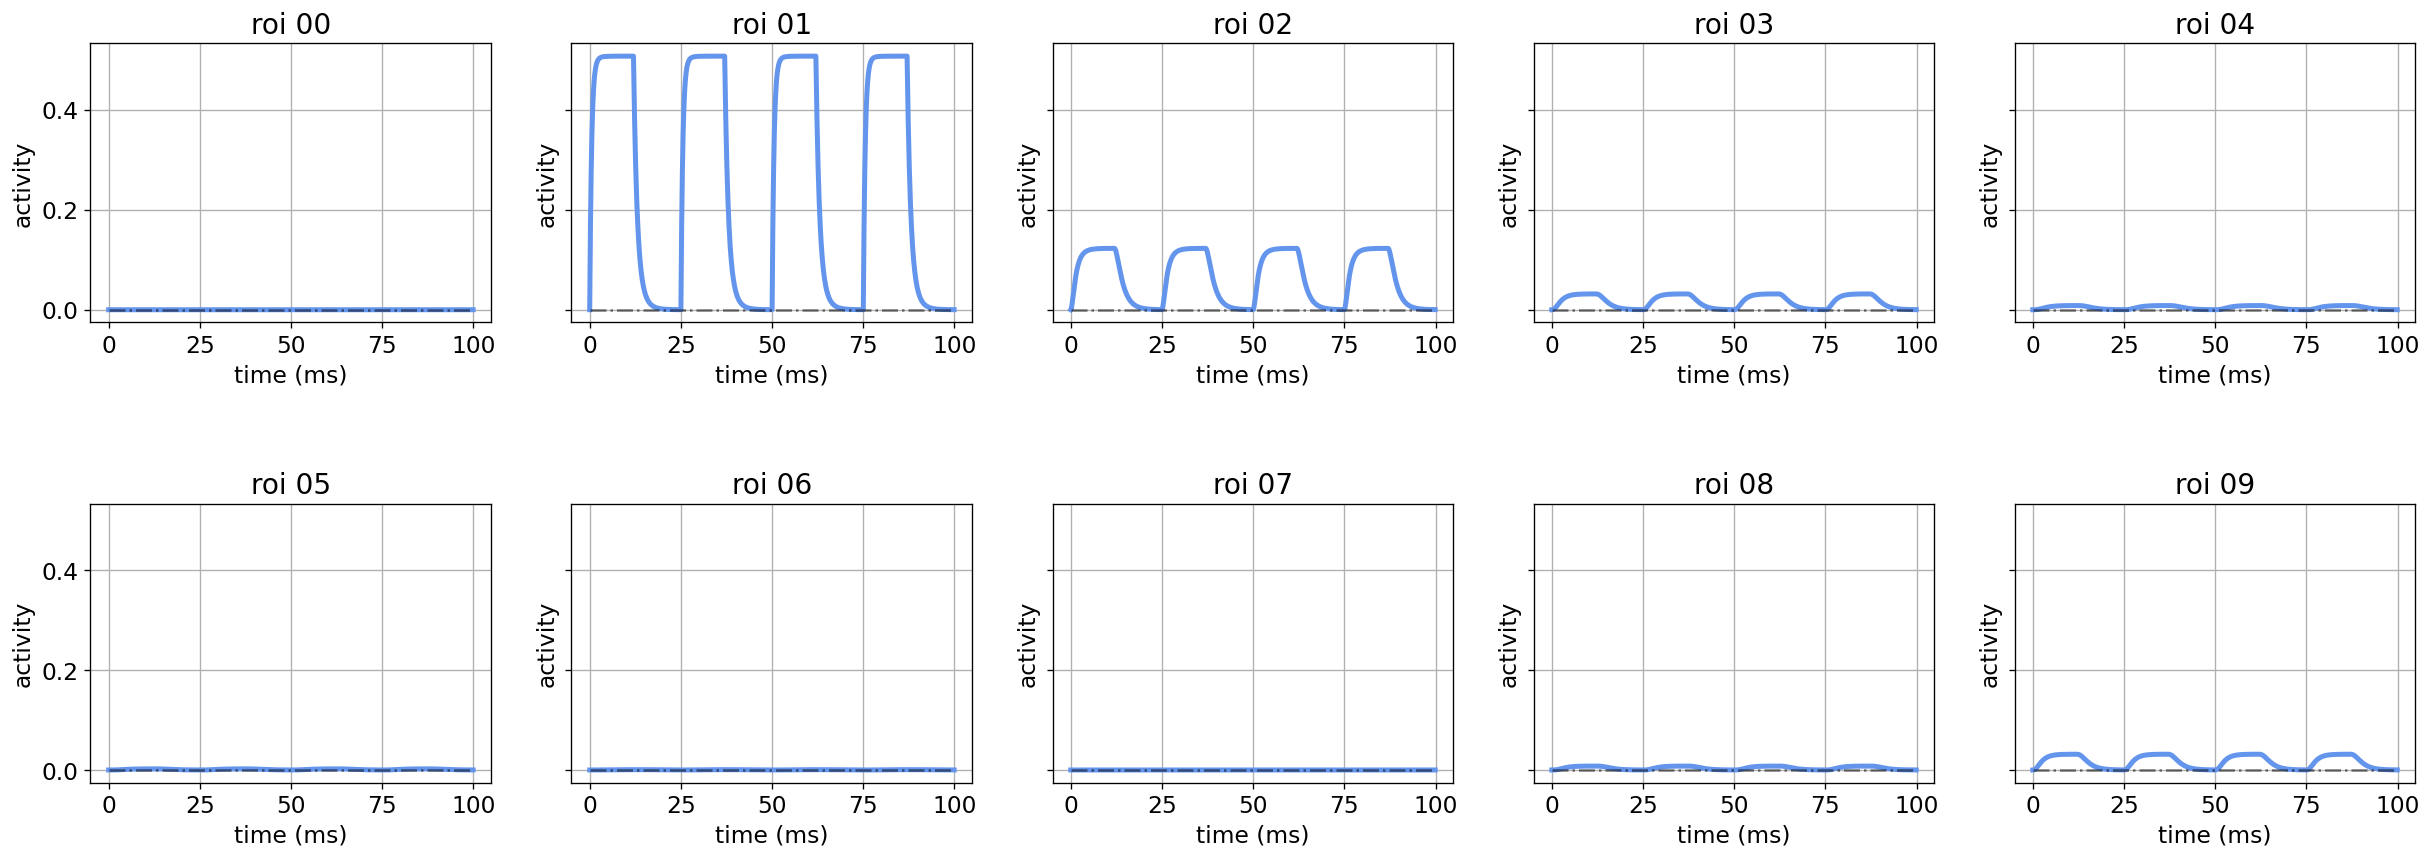

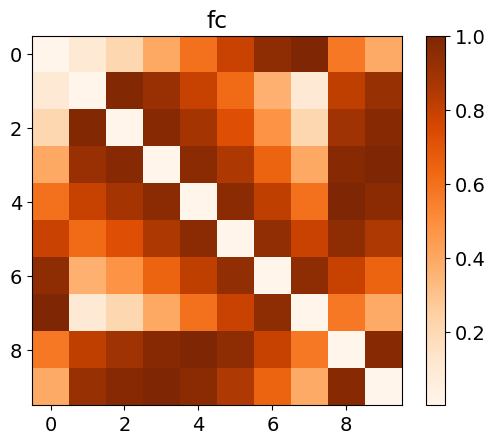

In [9]:
stim_rois = [1]
stimulus = np.zeros((args.num_rois[0],1))
stimulus[stim_rois] = 1.0

args.A = 1.0 * np.ones(shape=(args.num_rois[0],1))
args.A[1,:] = 1.0 

in_dict = {}
in_dict['W'] = networks[2]
in_dict['A'] = matlab.double(args.A)
in_dict['B'] = 1.0
in_dict['Iamp'] = 1.0
in_dict['tau'] = 12.0
in_dict['T'] = 25.0
in_dict['tspan'] = matlab.double(args.tspan)
in_dict['teval'] = matlab.double(
    np.arange(args.tspan[0], args.tspan[-1], args.delta_t)
)
in_dict['s'] = matlab.double(stimulus)
in_dict['sigma'] = 0.0

eng = matlab.engine.start_matlab()
model_path = f"{bdmodels_dir}"
model = eng.simulate_linear_sde_model
out_dict = simulate(eng, model_path, model, in_dict)
eng.quit()

args.subplot_layout = 'row-col'
plot_roi_time_series(
    args, 
    out_dict['t'],
    out_dict['x'],
)

plt.figure()
fc = stats.spearmanr(out_dict['x']).statistic
np.fill_diagonal(fc,1e-3,)
# fc = np.log(fc)
plt.imshow(fc, cmap=mpl.colormaps['Oranges'])
plt.colorbar()
plt.title('fc')

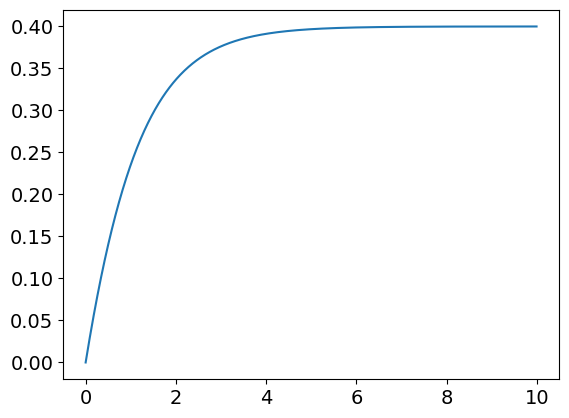

In [54]:
def f(x):
    return 1 / (1 + np.exp(-x)) - 0.5

A = args.A[2]
B = 1.0
x1 = np.arange(0.0, 10.0, 0.01)
x2 = (B * f(x1)) / (A + f(x1))
plt.plot(x1, x2)

## models

In [10]:
args.sigmas = np.linspace(start=0.0, stop=0.8, num=args.num_runs, endpoint=False)
args.sigmas

array([0.        , 0.26666667, 0.53333333])

In [11]:
stim_rois = [1]
stimulus = np.zeros((args.num_rois[0],1))
stimulus[stim_rois] = 1.0

args.A = 0.75 * np.ones(shape=(args.num_rois[0],1))

in_dict = {}
# in_dict['Kij'] = W
in_dict['A'] = matlab.double(args.A)
in_dict['B'] = 1.0
in_dict['Iamp'] = 1.0
in_dict['tau'] = 8.0
in_dict['T'] = 25.0
in_dict['tspan'] = matlab.double(args.tspan)
in_dict['teval'] = matlab.double(
    np.arange(args.tspan[0], args.tspan[-1], args.delta_t)
)
in_dict['s'] = matlab.double(stimulus)
# in_dict['sigma'] = 0.05

  0%|          | 0/27 [00:00<?, ?it/s]/home/govindas/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/govindas/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 27/27 [00:00<00:00, 50.84it/s]


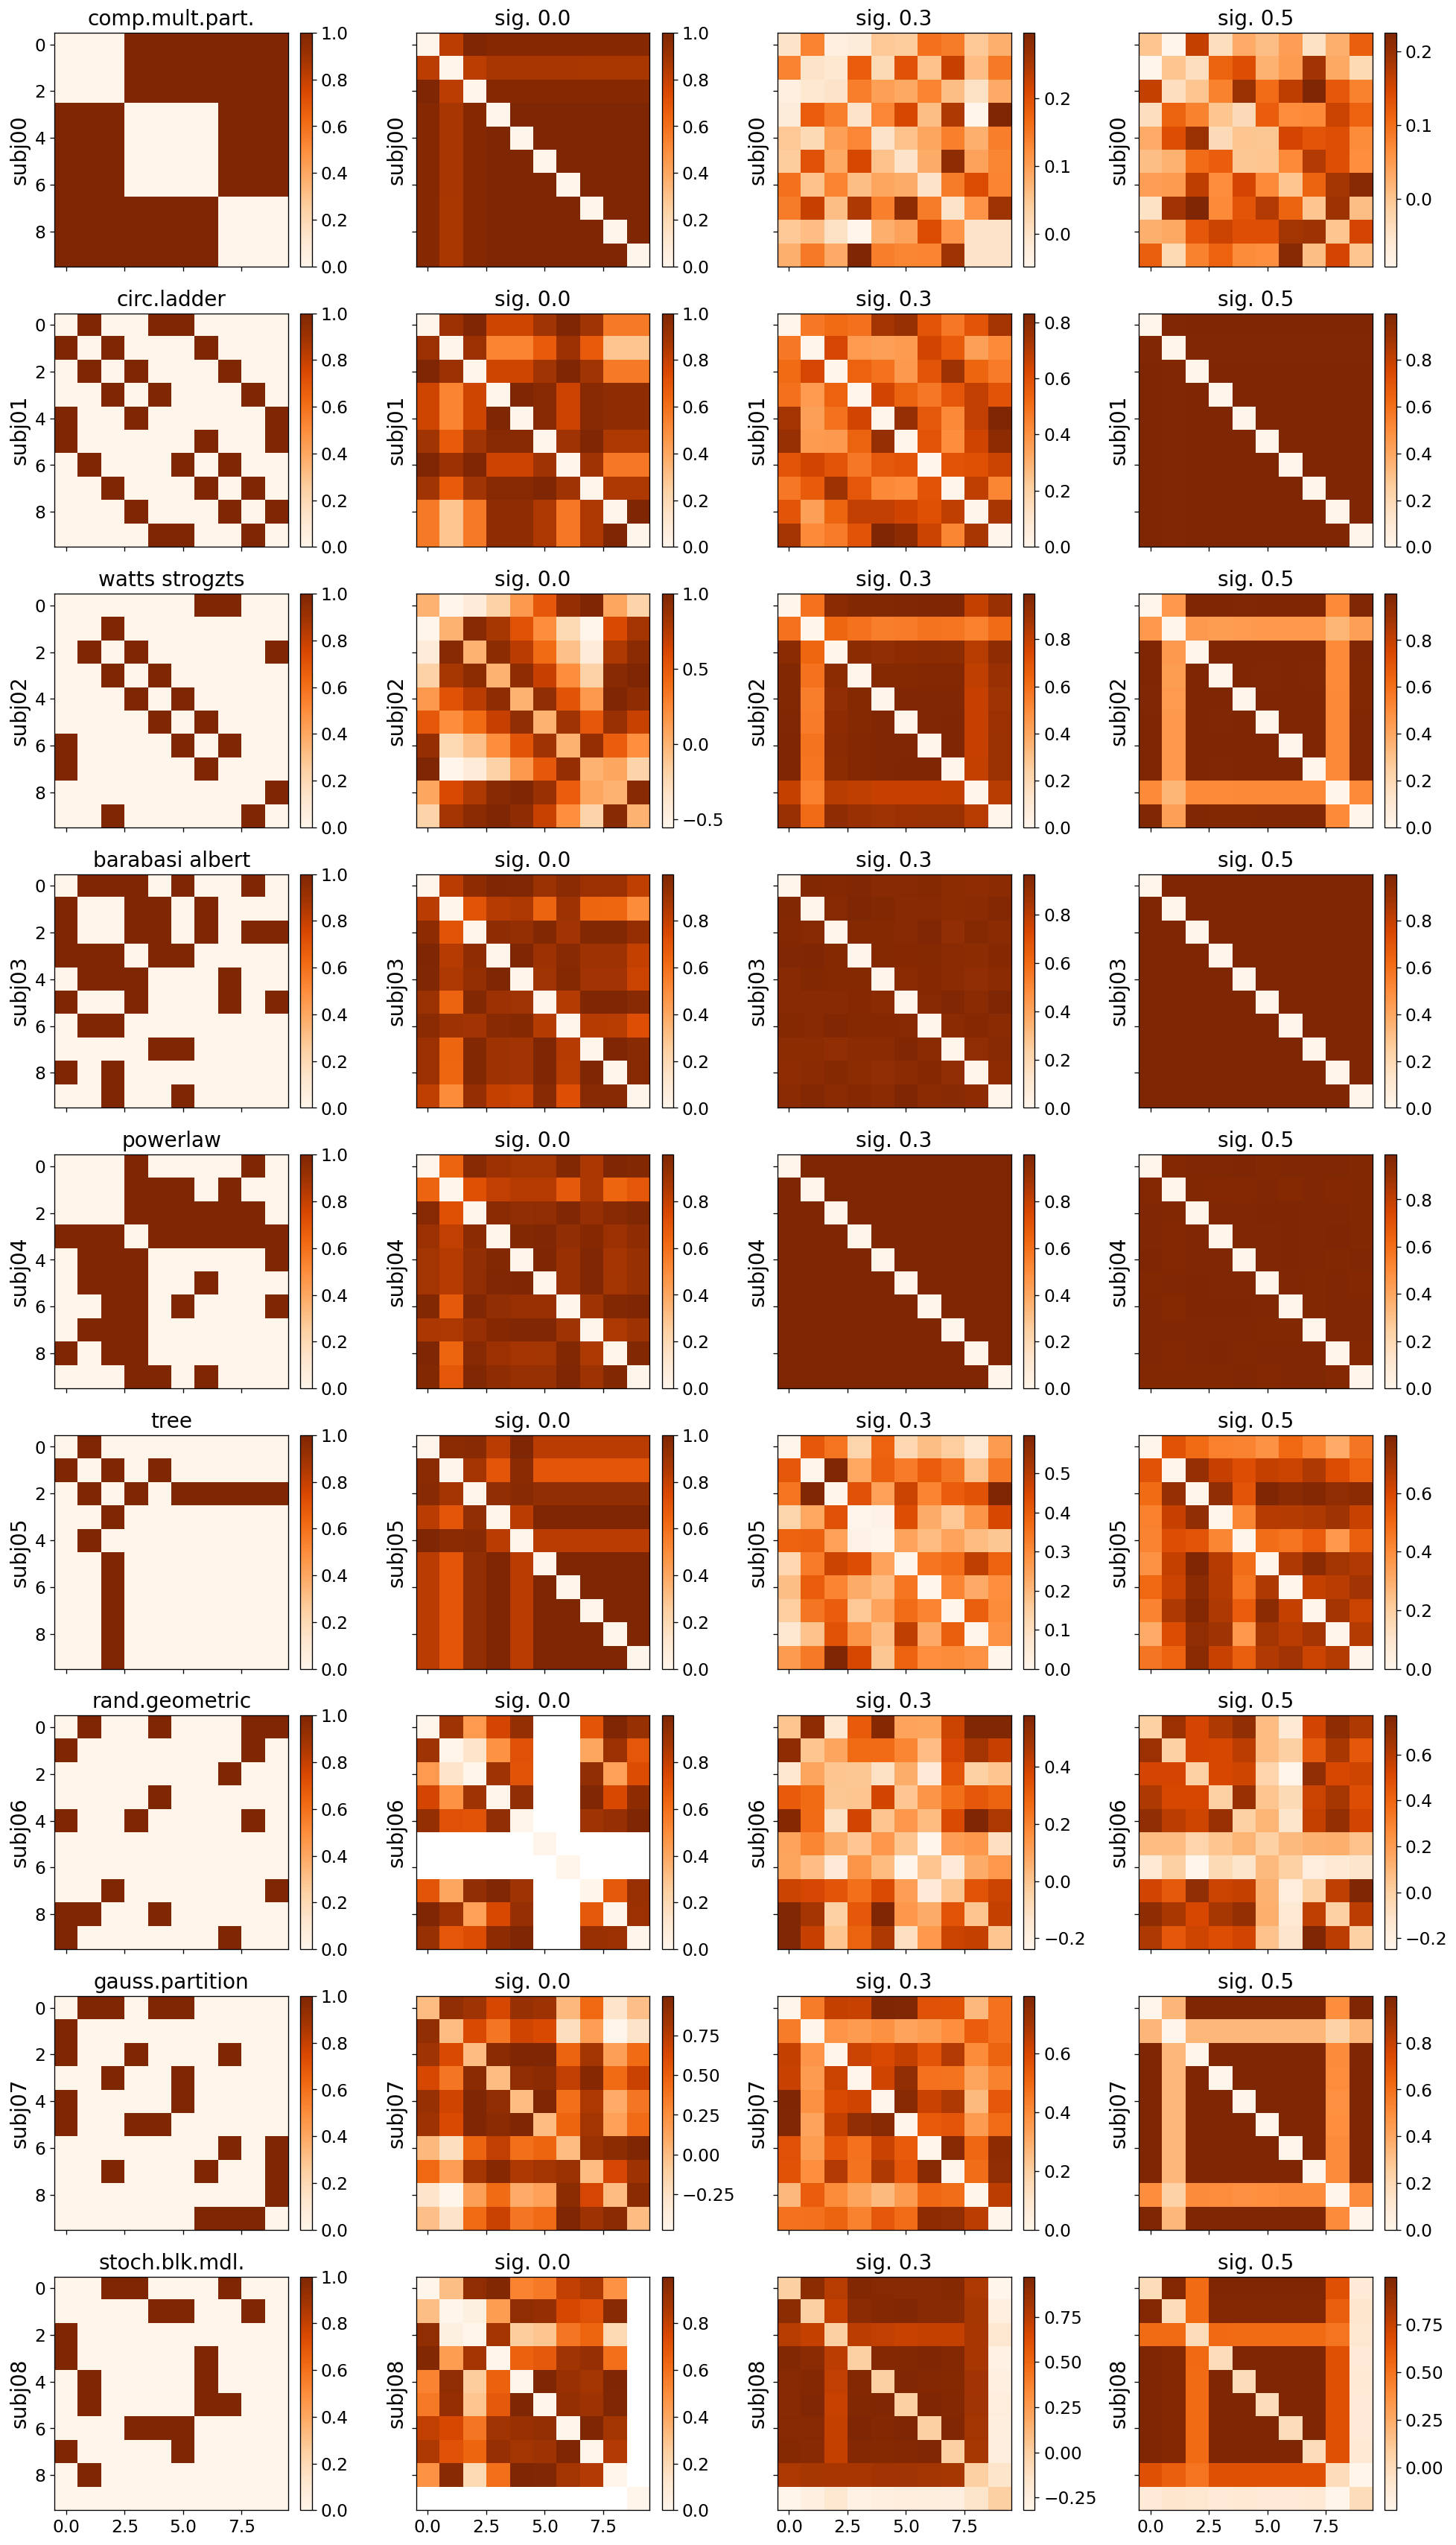

In [12]:
in_dicts = {
    f"subj{idx_subj:02}": {
        f"run{idx_run:02}": {}
        for idx_run in range(args.num_runs)
    } 
    for idx_subj in range(args.num_subjs)
}

out_dicts = copy.deepcopy(in_dicts)

# time series simulation
eng = matlab.engine.start_matlab()
model_path = f"{bdmodels_dir}"
model = eng.simulate_linear_sde_model
for (idx_subj, idx_run) in tqdm(
    list(product(range(args.num_subjs), range(args.num_runs)))
):
    in_dict['W'] = networks[idx_subj]
    in_dict['sigma'] = args.sigmas[idx_run]
    in_dicts[f"subj{idx_subj:02}"][f"run{idx_run:02}"] = copy.deepcopy(in_dict)
    
    out_dict = simulate(eng, model_path, model, in_dict)

    out_dicts[f"subj{idx_subj:02}"][f"run{idx_run:02}"] = copy.deepcopy(out_dict)
eng.quit()

sp.io.savemat(
    f"{bdmodels_dir}/in_dicts.mat",
    in_dicts,
)

# functional connectivity
fcs = {
    f"subj{idx_subj:02}": {
        f"run{idx_run:02}": None
        for idx_run in range(args.num_runs)
    } 
    for idx_subj in range(args.num_subjs)
}
for (idx_subj, idx_run) in tqdm(
    list(product(range(args.num_subjs), range(args.num_runs)))
):
    out_dict = copy.deepcopy(out_dicts[f"subj{idx_subj:02}"][f"run{idx_run:02}"])
    fc = stats.spearmanr(out_dict['x']).statistic
    np.fill_diagonal(fc, 0.0)
    # fc = np.log(fc)
    fcs[f"subj{idx_subj:02}"][f"run{idx_run:02}"] = fc
    
display_fcs(args, networks, fcs)

## testing

/tmp/ipykernel_31174/2079097722.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, (F1-G1), [0], colors='r', label='x1')
/tmp/ipykernel_31174/2079097722.py:15: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, F2 - G2, [0], colors='g', label='x2')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


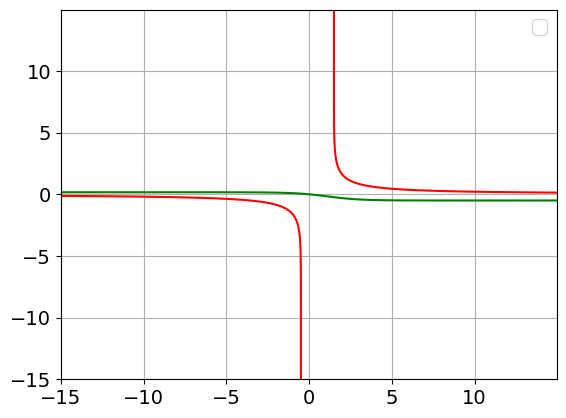

In [44]:
def f(x):
    return 1 / (1 + np.exp(-x)) - 0.5

A, B = 1, 0.5

delta = 0.025
xrange = np.arange(-15.0, 15.0, delta)
yrange = np.arange(-15.0, 15.0, delta)
X, Y = np.meshgrid(xrange, yrange)
F1 = -A * X
G1 = (B - X) * (f(Y) + 1)
plt.contour(X, Y, (F1-G1), [0], colors='r', label='x1')
F2 = -A * Y
G2 = (B - Y) * (f(X))
plt.contour(X, Y, F2 - G2, [0], colors='g', label='x2')
plt.legend()
plt.grid()

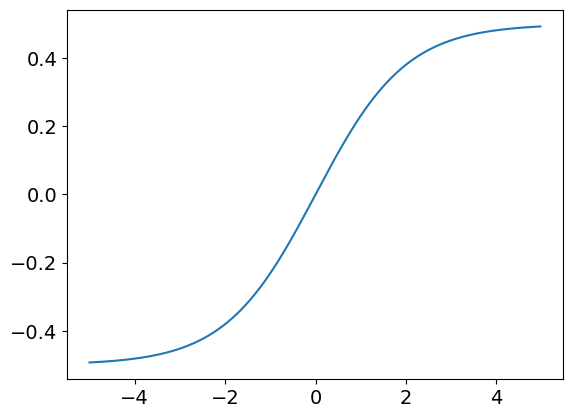

In [41]:
x = np.arange(-5, 5, delta)
plt.plot(x, f(x))